In [27]:
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
import seaborn as sns
import sklearn
from matplotlib import pyplot as plt

In [2]:
SEED = 224
DISPLAY = True
EXPORT = True
RECOMPUTE = False

# Import (with minimal preprocessing)

In [ ]:
orig_dat_1 = pd.read_excel("data/online_retail_II.xlsx",
                           sheet_name="Year 2009-2010", index_col=None,
                           keep_default_na=True, parse_dates=['InvoiceDate'])
orig_dat_2 = pd.read_excel("data/online_retail_II.xlsx",
                           sheet_name="Year 2010-2011", index_col=None,
                           keep_default_na=True, parse_dates=['InvoiceDate'])

In [45]:
# Remember to unzip data in data
orig_dat = (pd.read_csv("data/online_retail_II.csv", parse_dates=['InvoiceDate'])
         .rename(columns={"Customer ID":"CustomerID"})
)
dat = orig_dat.copy()
dat.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
dat.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'CustomerID', 'Country'],
      dtype='object')

In [69]:
# Note that Description is ONLY NULL when customer is null
orig_dat[pd.isnull(orig_dat.Description)].CustomerID.unique()

array([nan])

In [5]:
dat[dat['CustomerID'] == 17850.0] # one customer bought 312 things!

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
47,536372,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 09:01:00,1.85,17850.0,United Kingdom


In [47]:
# don't care about transactions with no item or no customer
dat = dat.dropna(subset=['StockCode', 'CustomerID'], how='any', axis=0) 
dat.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [49]:
dat.sort_values('Price') # A lot of the largest/smallest prices come from manual/discount

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
436597,574175,22065,CHRISTMAS PUDDING TRINKET POT,12,2011-11-03 11:47:00,0.00,14110.0,United Kingdom
314747,564651,22955,36 FOIL STAR CAKE CASES,144,2011-08-26 14:19:00,0.00,14646.0,Netherlands
314746,564651,23268,SET OF 2 CERAMIC CHRISTMAS REINDEER,192,2011-08-26 14:19:00,0.00,14646.0,Netherlands
198383,554037,22619,SET OF 6 SOLDIER SKITTLES,80,2011-05-20 14:13:00,0.00,12415.0,Australia
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.00,13081.0,United Kingdom
358670,568158,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-09-25 12:22:00,0.00,16133.0,United Kingdom
314745,564651,23270,SET OF 2 CERAMIC PAINTED HEARTS,96,2011-08-26 14:19:00,0.00,14646.0,Netherlands
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.00,13081.0,United Kingdom
157042,550188,22636,CHILDS BREAKFAST SET CIRCUS PARADE,1,2011-04-14 18:57:00,0.00,12457.0,Switzerland
361825,568384,M,Manual,1,2011-09-27 09:46:00,0.00,12748.0,United Kingdom


In [64]:
# Get rid of some of these manual codes
dat = dat[~dat.StockCode.isin(['M', 'POST', 'D', 'DOT', 'CRUK', 'C2', 'BANK CHARGES'])]
dat.sort_values('Price')

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
446794,574920,23480,MINI LIGHTS WOODLAND MUSHROOMS,1,2011-11-07 16:34:00,0.0,13985.0,United Kingdom
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10 13:08:00,0.0,17560.0,United Kingdom
379913,569716,22778,GLASS CLOCHE SMALL,2,2011-10-06 08:17:00,0.0,15804.0,United Kingdom
454463,575579,22437,SET OF 9 BLACK SKULL BALLOONS,20,2011-11-10 11:49:00,0.0,13081.0,United Kingdom
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2011-03-30 12:45:00,0.0,13113.0,United Kingdom
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,13256.0,United Kingdom
314745,564651,23270,SET OF 2 CERAMIC PAINTED HEARTS,96,2011-08-26 14:19:00,0.0,14646.0,Netherlands
279323,561284,22167,OVAL WALL MIRROR DIAMANTE,1,2011-07-26 12:24:00,0.0,16818.0,United Kingdom
314746,564651,23268,SET OF 2 CERAMIC CHRISTMAS REINDEER,192,2011-08-26 14:19:00,0.0,14646.0,Netherlands
198383,554037,22619,SET OF 6 SOLDIER SKITTLES,80,2011-05-20 14:13:00,0.0,12415.0,Australia


In [70]:
# end preprocessing

# First pass at graph

In [7]:
G = nx.MultiGraph()

In [71]:
edges = list(zip(dat.StockCode, dat.CustomerID.astype(int)))
len(edges)

404913

In [9]:
for edge in tqdm(edges):
    G.add_edge(edge[0], edge[1])

100%|██████████| 406830/406830 [00:01<00:00, 347022.30it/s]


In [10]:
len(G.nodes), len(G.edges)

(8056, 406830)

# Degree analysis

In [11]:
degrees = G.degree
import collections
degree_count = dict(collections.Counter(dict(degrees).values()))

In [12]:
degree_count

{2077: 1,
 312: 5,
 272: 6,
 250: 5,
 330: 7,
 333: 4,
 306: 8,
 129: 11,
 477: 1,
 379: 2,
 974: 1,
 196: 10,
 97: 30,
 93: 26,
 140: 18,
 1418: 1,
 329: 5,
 360: 1,
 421: 4,
 53: 50,
 75: 27,
 226: 2,
 236: 5,
 719: 1,
 582: 2,
 5: 133,
 539: 1,
 257: 3,
 638: 1,
 251: 4,
 932: 1,
 831: 1,
 57: 36,
 94: 29,
 49: 44,
 494: 2,
 227: 5,
 627: 1,
 728: 1,
 547: 4,
 267: 2,
 353: 5,
 546: 2,
 399: 5,
 91: 20,
 66: 31,
 335: 3,
 1197: 1,
 1029: 1,
 28: 82,
 274: 7,
 125: 14,
 286: 6,
 111: 22,
 566: 2,
 590: 2,
 905: 1,
 836: 1,
 124: 20,
 6: 149,
 524: 1,
 109: 15,
 709: 1,
 903: 1,
 359: 4,
 673: 1,
 110: 23,
 512: 2,
 311: 3,
 328: 1,
 1359: 1,
 448: 1,
 340: 3,
 1080: 1,
 569: 1,
 692: 1,
 698: 1,
 61: 39,
 107: 23,
 800: 1,
 618: 1,
 888: 1,
 64: 31,
 849: 2,
 2491: 1,
 1: 240,
 814: 1,
 151: 11,
 322: 5,
 103: 21,
 338: 7,
 35: 66,
 99: 20,
 289: 8,
 144: 14,
 361: 4,
 624: 1,
 708: 1,
 16: 100,
 9: 108,
 452: 3,
 118: 24,
 80: 34,
 193: 9,
 194: 10,
 332: 1,
 52: 45,
 296: 3,
 388: 

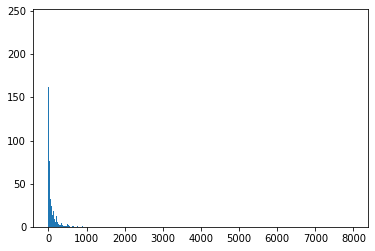

In [13]:
if (DISPLAY):
    plt.hist(dict(degrees).values(), bins=8000)
    plt.show()

# Spectral analysis

In [14]:
node_ordering = G.nodes()

In [15]:
Adj = nx.linalg.adjacency_matrix(G)

In [16]:
# Spectral Clustering
from sklearn.manifold import SpectralEmbedding
model = SpectralEmbedding(n_components=2,
                              affinity='precomputed',
                              random_state=SEED,
                              n_neighbors=None,
                              n_jobs=None)
embedding = model.fit_transform(Adj.toarray())

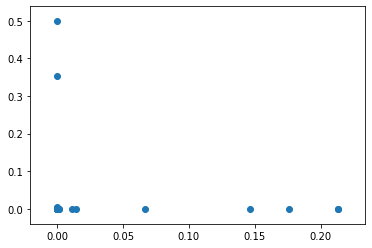

In [17]:
if (DISPLAY):
    # plot Spectral Clustering
    plt.scatter(embedding[:,0], embedding[:, 1])
    plt.show()

In [18]:
# t-SNE
from sklearn.manifold import TSNE

model = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0,
             learning_rate=200.0, n_iter=1000, n_iter_without_progress=300,
             min_grad_norm=1e-07, random_state=SEED)
embedding = model.fit_transform(embedding)

In [19]:
embedding = pd.DataFrame(embedding, index=node_ordering)
embedding.head()

,0,1
85123A,43.935493,40.383518
17850,9.905036,9.681977
71053,48.904305,51.116219
84406B,56.073315,17.167192
84029G,75.590050,-6.891227


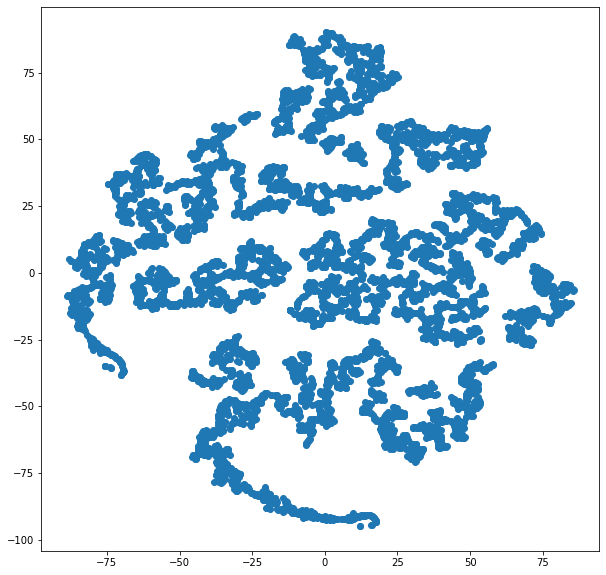

In [20]:
if (DISPLAY):
    # plot t-SNE
    plt.figure(figsize=(10, 10))
    plt.scatter(embedding.iloc[:,0], embedding.iloc[:, 1])

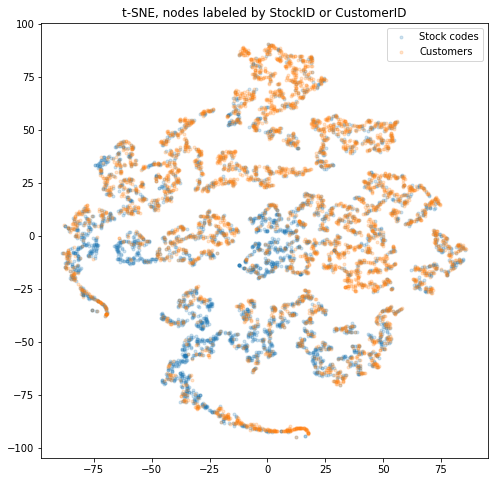

In [21]:
if (DISPLAY):
    plt.figure(figsize=(8, 8))
    plt.rcParams["scatter.marker"] = '.'
    group1 = edge_dat.StockCode.unique()
    group2 = edge_dat.CustomerID.unique()
    plt.scatter(embedding.loc[group1].iloc[:,0],
                embedding.loc[group1].iloc[:,1], alpha=0.2, label="Stock codes", marker='.')
    plt.scatter(embedding.loc[group2].iloc[:,0],
                embedding.loc[group2].iloc[:,1], alpha=0.2, label="Customers", marker='.')
    plt.legend()
    plt.title("t-SNE, nodes labeled by StockID or CustomerID")

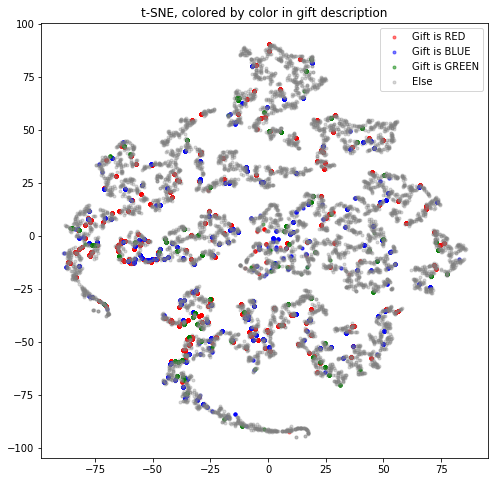

In [22]:
if (DISPLAY):
    plt.figure(figsize=(8, 8))
    group1 = edge_dat[edge_dat.Description.str.contains("RED")].StockCode
    group2 = edge_dat[edge_dat.Description.str.contains("BLUE")].StockCode
    group3 = edge_dat[edge_dat.Description.str.contains("GREEN")].StockCode
    group4 = embedding.index.difference(pd.concat([group3, group2, group1]))

    plt.scatter(embedding.loc[group1].iloc[:,0],
                embedding.loc[group1].iloc[:,1], alpha=0.5, color='red', label="Gift is RED")
    plt.scatter(embedding.loc[group2].iloc[:,0],
                embedding.loc[group2].iloc[:,1], alpha=0.5, color='blue', label="Gift is BLUE")
    plt.scatter(embedding.loc[group3].iloc[:,0],
                embedding.loc[group3].iloc[:,1], alpha=0.5, color='green', label="Gift is GREEN")
    plt.scatter(embedding.loc[group4].iloc[:,0],
                embedding.loc[group4].iloc[:,1], alpha=0.3, color='grey', label="Else")

    plt.legend()
    plt.title("t-SNE, colored by color in gift description")

In [23]:
if (DISPLAY):
    # Slow - only draw subgraphs
    # nx.draw_networkx(G, pos=None, arrows=True, with_labels=True)
    pass

# Build graphs with node and edge features

In [24]:
# boolean settings
params = [
    ("directed", "undirected"),
    ("stock_and_customer", "stock_only", "customer_only"), # bipartite or contracted bipartite
    ("multi", "simple")
]

In [97]:
bins = pd.date_range(start=dat.InvoiceDate.min(), end=dat.InvoiceDate.max(), freq='W')
bins, len(bins), dat.InvoiceDate.min(), dat.InvoiceDate.max()

(DatetimeIndex(['2010-12-05 08:26:00', '2010-12-12 08:26:00',
                '2010-12-19 08:26:00', '2010-12-26 08:26:00',
                '2011-01-02 08:26:00', '2011-01-09 08:26:00',
                '2011-01-16 08:26:00', '2011-01-23 08:26:00',
                '2011-01-30 08:26:00', '2011-02-06 08:26:00',
                '2011-02-13 08:26:00', '2011-02-20 08:26:00',
                '2011-02-27 08:26:00', '2011-03-06 08:26:00',
                '2011-03-13 08:26:00', '2011-03-20 08:26:00',
                '2011-03-27 08:26:00', '2011-04-03 08:26:00',
                '2011-04-10 08:26:00', '2011-04-17 08:26:00',
                '2011-04-24 08:26:00', '2011-05-01 08:26:00',
                '2011-05-08 08:26:00', '2011-05-15 08:26:00',
                '2011-05-22 08:26:00', '2011-05-29 08:26:00',
                '2011-06-05 08:26:00', '2011-06-12 08:26:00',
                '2011-06-19 08:26:00', '2011-06-26 08:26:00',
                '2011-07-03 08:26:00', '2011-07-10 08:26:00',
        

In [100]:
len(orig_dat), len(dat)

(541910, 404913)

In [72]:
import networkx as nx
import os

class TemporalGraph:
    
    def __init__(self, node_ordering, index):
        self.frames = {}
        self.index = index # save this as an accessor to which bins exist
        self.node_ordering = node_ordering
    
    def add_frame(self, ind, frame):
        self.frames[ind] = frame
        
    def get_frame(self, ind):
        """ Returns a copy of the frame at the index.
        """
        return self.frames[ind].copy()
        
    def read_gpickles(self, directory):
        for ind_path in os.listdir(directory):
            ind = os.path.basename(ind_path).split(".")[0]
            self.frames[ind] = nx.read_gpickle(ind_path)
            
    def write_gpickles(self, directory):
        for ind, frame in self.frames.items():
            nx.write_gpickle(frame, os.path.join(directory, "%s.pkl" % ind))

## Some descriptions are misspelled/updated later.
We'll keep the last occurrence.

In [83]:
duplicated = dat[['StockCode', 'Description']].drop_duplicates().sort_values('StockCode')
duplicated[duplicated.duplicated(subset=['StockCode'], keep=False)]

,StockCode,Description
138080,16156L,WRAP CAROUSEL
47284,16156L,"WRAP, CAROUSEL"
315743,17107D,FLOWER FAIRY 5 DRAWER LINERS
6467,17107D,"FLOWER FAIRY,5 SUMMER B'DRAW LINERS"
347764,17107D,FLOWER FAIRY 5 SUMMER DRAW LINERS
29444,20622,VIPPASSPORT COVER
247444,20622,VIP PASSPORT COVER
93,20725,LUNCH BAG RED RETROSPOT
58132,20725,LUNCH BAG RED SPOTTY
415,20914,SET/5 RED RETROSPOT LID GLASS BOWLS


In [95]:
def create_frame(dat):
    G = nx.Graph()
    
    #Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
    #   'Price', 'CustomerID', 'Country'],
    #  dtype='object')
        
    custData = dat[['CustomerID', 'Country']].drop_duplicates(subset=['CustomerID'], keep='last')
    stockData = dat[['StockCode', 'Description']].drop_duplicates(subset=['StockCode'], keep='last')
    
    assert len(custData) == len(custData.CustomerID.unique())
    assert len(stockData) == len(stockData.StockCode.unique())
    
    for i, stock in stockData.iterrows():
        G.add_node(stock.StockCode,
                   description=stock.Description)
    
    for i, customer in custData.iterrows():
        G.add_node(customer.CustomerID,
                   country=customer.Country)
        
    for i, row in dat.iterrows():
        G.add_edge(row.StockCode,
                   row.CustomerID,
                   key=row.Invoice,
                   quantity=row.Quantity,
                   date=row.InvoiceDate,
                   price=row.Price) # sometimes price changes, sale?
        
    return G

In [96]:
import temporal

TG = temporal.TemporalGraph(node_ordering, bins)

for i in range(len(bins) - 1):
    start = bins[i]
    end = bins[i+1]
    print(start, end)
    bin_dat = dat[(dat.InvoiceDate >= start) & (dat.InvoiceDate < end)]
    frame = create_frame(bin_dat)
    TG.add_frame(start, frame)
    print(len(bin_dat))

2010-12-05 08:26:00 2010-12-12 08:26:00
11074
2010-12-12 08:26:00 2010-12-19 08:26:00
8164
2010-12-19 08:26:00 2010-12-26 08:26:00
2386
2010-12-26 08:26:00 2011-01-02 08:26:00
0
2011-01-02 08:26:00 2011-01-09 08:26:00
4281
2011-01-09 08:26:00 2011-01-16 08:26:00
5256
2011-01-16 08:26:00 2011-01-23 08:26:00
4545
2011-01-23 08:26:00 2011-01-30 08:26:00
5974
2011-01-30 08:26:00 2011-02-06 08:26:00
5596
2011-02-06 08:26:00 2011-02-13 08:26:00
3660
2011-02-13 08:26:00 2011-02-20 08:26:00
5075
2011-02-20 08:26:00 2011-02-27 08:26:00
5901
2011-02-27 08:26:00 2011-03-06 08:26:00
5638
2011-03-06 08:26:00 2011-03-13 08:26:00
5806
2011-03-13 08:26:00 2011-03-20 08:26:00
5471
2011-03-20 08:26:00 2011-03-27 08:26:00
7029
2011-03-27 08:26:00 2011-04-03 08:26:00
6642
2011-04-03 08:26:00 2011-04-10 08:26:00
6093
2011-04-10 08:26:00 2011-04-17 08:26:00
6567
2011-04-17 08:26:00 2011-04-24 08:26:00
5969
2011-04-24 08:26:00 2011-05-01 08:26:00
3323
2011-05-01 08:26:00 2011-05-08 08:26:00
5172
2011-05-08 0

In [ ]:
# bipartite
node_id = ['StockCode', 'CustomerID', ]
edge_features = ['Invoice', 'Quantity', 'InvoiceDate',]
nodes_features = ['Description', 'Price', 'Country']

# stockcodes only
node_id = ['StockCode',]
edge_features = ['Invoice', 'Quantity', 'InvoiceDate', 'CustomerID',  'Country']
nodes_features = ['Description', 'Price', ]

# bipartite
node_id = ['CustomerID', ]
edge_features = ['StockCode', 'Description', 'Price', 'Invoice', 'Quantity', 'InvoiceDate',]
nodes_features = ['Country']